# Image to video with gpt-4o and Sora

Sora is an AI model from OpenAI that can create realistic and imaginative video scenes from text instructions. The model is capable of generating a wide range of video content, including realistic scenes, animations, and special effects. Several video resolutions and durations are supported.

https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/video-generation

In [1]:
import base64
import cv2
import datetime
import numpy as np
import openai
import os
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Image, Video, FileLink, Audio
from mimetypes import guess_type
from openai import AzureOpenAI

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 02-Jun-2025 11:47:15


## Settings

In [4]:
load_dotenv("azure.env")

endpoint = os.environ['AZURE_OPENAI_ENDPOINT']
api_key = os.environ['AZURE_OPENAI_API_KEY']

api_version = "2025-04-01-preview"
model = "gpt-4o"
sora_model = "sora"

In [5]:
IMAGES_DIR = "images"

In [6]:
OUTPUT_DIR = "videos"

os.makedirs(OUTPUT_DIR, exist_ok=True)

## Helper

In [7]:
def local_image_to_data_url(image_path):
    """
    Converts a local image file to a data URL.

    Parameters:
    image_path (str): Path to the local image file.

    Returns:
    str: A data URL containing the base64-encoded image data.
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(
            image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [8]:
def describe_image_with_gpt4o(image_file, prompt):
    """
    Uses GPT-4o to analyze an image.

    Parameters:
    image_file (str): Path to the image file to be analyzed.
    prompt (str): Text prompt describing what to analyze in the image.

    Returns:
    str: The description generated by GPT-4o based on the image and prompt.

    The function initializes an AzureOpenAI client, sends a request to the GPT-4o model with the image and prompt, 
    and returns the generated description. The image is converted to a data URL before being sent to the model.
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{endpoint}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role":
                "system",
                "content":
                "You are an AI helpful assistant to analyse an image.",
            },
            {
                "role":
                "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": local_image_to_data_url(image_file)
                        },
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response.choices[0].message.content

In [9]:
def sora(prompt, width=480, height=480, n_seconds=5):
    """
    Generates a video based on the given prompt using the SORA model.

    Parameters:
    prompt (str): The text prompt to generate the video.
    width (int): The width of the video. Supported values are 480, 854, 720, 1080, and 1920.
    height (int): The height of the video. Supported values are 480, 854, 720, 1080, and 1920.
    n_seconds (int): The duration of the video in seconds. Must be between 1 and 20 seconds.
    n_variants (int): The number of video variants to generate.
    
    Returns:
    str: The filename of the generated video.

    Raises:
    Exception: If the video generation job fails or no generations are found.
    """
    start = time.time()

    api_version = 'preview'
    headers = {"api-key": api_key, "Content-Type": "application/json"}

    idx = datetime.datetime.today().strftime('%d%b%Y_%H%M%S')
    output_filename = os.path.join(OUTPUT_DIR, f"image_to_video_sora_{idx}_{image_file.split('/')[-1].split('.')[0]}.mp4")

    # 1. Create a video generation job
    create_url = f"{endpoint}/openai/v1/video/generations/jobs?api-version={api_version}"
    body = {
        "prompt": prompt,
        "width": width,  # 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080.
        "height": height,  # 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080.
        "n_seconds": n_seconds,  # between 1 and 20 seconds
        "model": sora_model,  # SORA model
    }
    response = requests.post(create_url, headers=headers, json=body)
    response.raise_for_status()

    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
    print(f"{now} Full response JSON:", response.json())
    print()

    job_id = response.json()["id"]
    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
    print(f"{now} Job created: {job_id}")

    # 2. Poll for job status
    status_url = f"{endpoint}/openai/v1/video/generations/jobs/{job_id}?api-version={api_version}"
    status = None

    while status not in ("succeeded", "failed", "cancelled"):
        time.sleep(5)  # Wait before polling again
        status_response = requests.get(status_url, headers=headers).json()
        status = status_response.get("status")
        now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
        print(f"{now} Job status: {status}")

    # 3. Retrieve generated video
    if status == "succeeded":
        generations = status_response.get("generations", [])
        
        if generations:
            now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
            print(f"\n{now} ✅ Done. Video generation succeeded.")
            generation_id = generations[0].get("id")
            video_url = f"{endpoint}/openai/v1/video/generations/{generation_id}/content/video?api-version={api_version}"
            video_response = requests.get(video_url, headers=headers)

            if video_response.ok:
                # Downloading the video
                print("\nDownloading the video...")
                with open(output_filename, "wb") as file:
                    file.write(video_response.content)
                    print(f"SORA Generated video saved: '{output_filename}'")

                elapsed = time.time() - start
                minutes, seconds = divmod(elapsed, 60)
                print(
                    f"Done in {minutes:.0f} minutes and {seconds:.0f} seconds")

                return output_filename
        else:
            raise Exception("Error. No generations found in job result.")
    else:
        raise Exception(f"Error. Job did not succeed. Status: {status}")

## Example 1

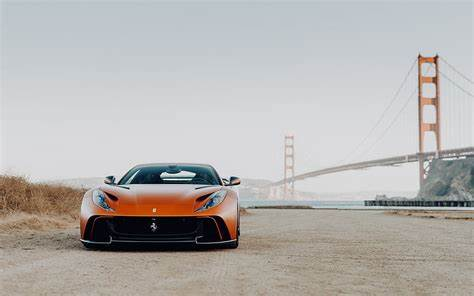

In [10]:
image_file = os.path.join(IMAGES_DIR, "car.jpg")

Image(image_file, width=640)

In [11]:
description = describe_image_with_gpt4o(image_file, "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features")

print(description)

This image depicts an orange Ferrari sports car positioned in the foreground, centered in the frame. The car is parked on a sandy or dirt pathway, with its sleek, aerodynamic design and low profile emphasized. Its vibrant orange color contrasts sharply with the neutral tones of the surrounding environment. The front grille features the iconic Ferrari logo, and the car's headlights have a sharp, aggressive design, adding to its sporty aesthetic.

In the background, the Golden Gate Bridge is prominently visible, spanning across the image from the right side to the center-left. The bridge's rust-red color complements the orange of the car, and it is set against a pale, overcast sky. The bridge's structure, including its tall towers and suspension cables, is clearly defined, adding an iconic architectural element to the composition.

To the left of the car, there is a patch of dry grass, suggesting a natural, coastal setting. The ground beneath the car appears to be unpaved, adding texture

In [12]:
sora_prompt = f"Based on the following descriptions of an image:\n {description} \nPlease create a coherent generative AI prompt that can be used to generate a video."

print(sora_prompt)

Based on the following descriptions of an image:
 This image depicts an orange Ferrari sports car positioned in the foreground, centered in the frame. The car is parked on a sandy or dirt pathway, with its sleek, aerodynamic design and low profile emphasized. Its vibrant orange color contrasts sharply with the neutral tones of the surrounding environment. The front grille features the iconic Ferrari logo, and the car's headlights have a sharp, aggressive design, adding to its sporty aesthetic.

In the background, the Golden Gate Bridge is prominently visible, spanning across the image from the right side to the center-left. The bridge's rust-red color complements the orange of the car, and it is set against a pale, overcast sky. The bridge's structure, including its tall towers and suspension cables, is clearly defined, adding an iconic architectural element to the composition.

To the left of the car, there is a patch of dry grass, suggesting a natural, coastal setting. The ground ben

In [13]:
generated_video_file = sora(sora_prompt, width=1280, height=720, n_seconds=7)

02-Jun-2025 11:47:24 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwr7fggmfq7tqf070vrg8914', 'status': 'queued', 'created_at': 1748864844, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': "Based on the following descriptions of an image:\n This image depicts an orange Ferrari sports car positioned in the foreground, centered in the frame. The car is parked on a sandy or dirt pathway, with its sleek, aerodynamic design and low profile emphasized. Its vibrant orange color contrasts sharply with the neutral tones of the surrounding environment. The front grille features the iconic Ferrari logo, and the car's headlights have a sharp, aggressive design, adding to its sporty aesthetic.\n\nIn the background, the Golden Gate Bridge is prominently visible, spanning across the image from the right side to the center-left. The bridge's rust-red color complements the orange of the car, and it is set against a pale, overcast sky. The bridge's structure, 

In [14]:
Video(generated_video_file, width=1024)

In [15]:
video_link = FileLink(path=generated_video_file)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/image_to_video_sora_02Jun2025_114723_car.mp4

In [16]:
# Mixing the initial image on the left and the SORA video on the right
output_path = os.path.join(OUTPUT_DIR, "image_sora_car.mp4")

left_image = cv2.imread(image_file)
video = cv2.VideoCapture(generated_video_file)

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
left_image_resized = cv2.resize(
    left_image,
    (int(height * left_image.shape[1] / left_image.shape[0]), height))
combined_width = left_image_resized.shape[1] + width
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, height))

while True:
    ret, frame = video.read()
    if not ret:
        break
    combined_frame = np.hstack((left_image_resized, frame))
    out.write(combined_frame)

video.release()
out.release()

video_link = FileLink(path=output_path)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/image_sora_car.mp4

## Example 2

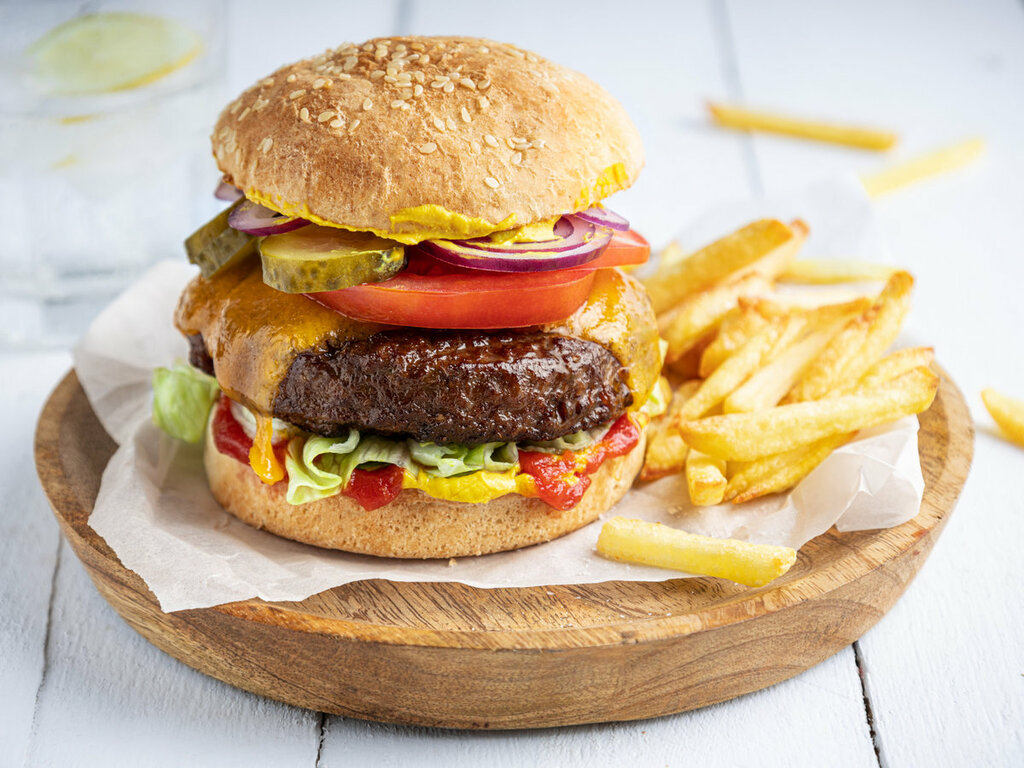

In [17]:
image_file = os.path.join(IMAGES_DIR, "food.jpg")

Image(image_file, width=640)

In [18]:
description = describe_image_with_gpt4o(image_file, "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features")

print(description)

The image showcases a delicious and visually appealing meal consisting of a cheeseburger and French fries, placed on a wooden plate. The scene is set on a white wooden surface, creating a clean and simple background that contrasts well with the vibrant colors of the food.

### Main Objects:
1. **Cheeseburger**:
   - Positioned centrally on the wooden plate and is the focus of the image.
   - The bun is golden brown with sesame seeds sprinkled on top, and a smear of mustard is visible along its edge.
   - The filling includes:
     - **Tomato slices**: A bright red and juicy layer, positioned just below the top bun.
     - **Pickles**: Sliced and green, placed beneath the tomato.
     - **Red onion slices**: Thinly cut rings with a vibrant purple hue.
     - **Cheddar cheese**: Melted over the beef patty, with its sharp yellow-orange color dripping slightly.
     - **Beef patty**: Thick and well-grilled, with a dark brown seared surface that appears juicy.
     - **Lettuce leaves**: Cur

In [19]:
sora_prompt = f"Based on the following descriptions of an image:\n {description} \nPlease create a coherent generative AI prompt that can be used to generate a video."

In [20]:
generated_video_file = sora(sora_prompt, width=1280, height=720, n_seconds=5)

02-Jun-2025 11:49:04 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwr7jhzvfysrab753y44dbrp', 'status': 'queued', 'created_at': 1748864944, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': "Based on the following descriptions of an image:\n The image showcases a delicious and visually appealing meal consisting of a cheeseburger and French fries, placed on a wooden plate. The scene is set on a white wooden surface, creating a clean and simple background that contrasts well with the vibrant colors of the food.\n\n### Main Objects:\n1. **Cheeseburger**:\n   - Positioned centrally on the wooden plate and is the focus of the image.\n   - The bun is golden brown with sesame seeds sprinkled on top, and a smear of mustard is visible along its edge.\n   - The filling includes:\n     - **Tomato slices**: A bright red and juicy layer, positioned just below the top bun.\n     - **Pickles**: Sliced and green, placed beneath the tomato.\n     - **Red onion

In [21]:
Video(generated_video_file, width=1024)

In [22]:
video_link = FileLink(path=generated_video_file)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/image_to_video_sora_02Jun2025_114903_food.mp4

In [23]:
# Mixing the initial image on the left and the SORA video on the right
output_path = os.path.join(OUTPUT_DIR, "image_sora_food.mp4")

left_image = cv2.imread(image_file)
video = cv2.VideoCapture(generated_video_file)

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
left_image_resized = cv2.resize(
    left_image,
    (int(height * left_image.shape[1] / left_image.shape[0]), height))
combined_width = left_image_resized.shape[1] + width
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, height))

while True:
    ret, frame = video.read()
    if not ret:
        break
    combined_frame = np.hstack((left_image_resized, frame))
    out.write(combined_frame)

video.release()
out.release()

video_link = FileLink(path=output_path)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/image_sora_food.mp4

## Example 3

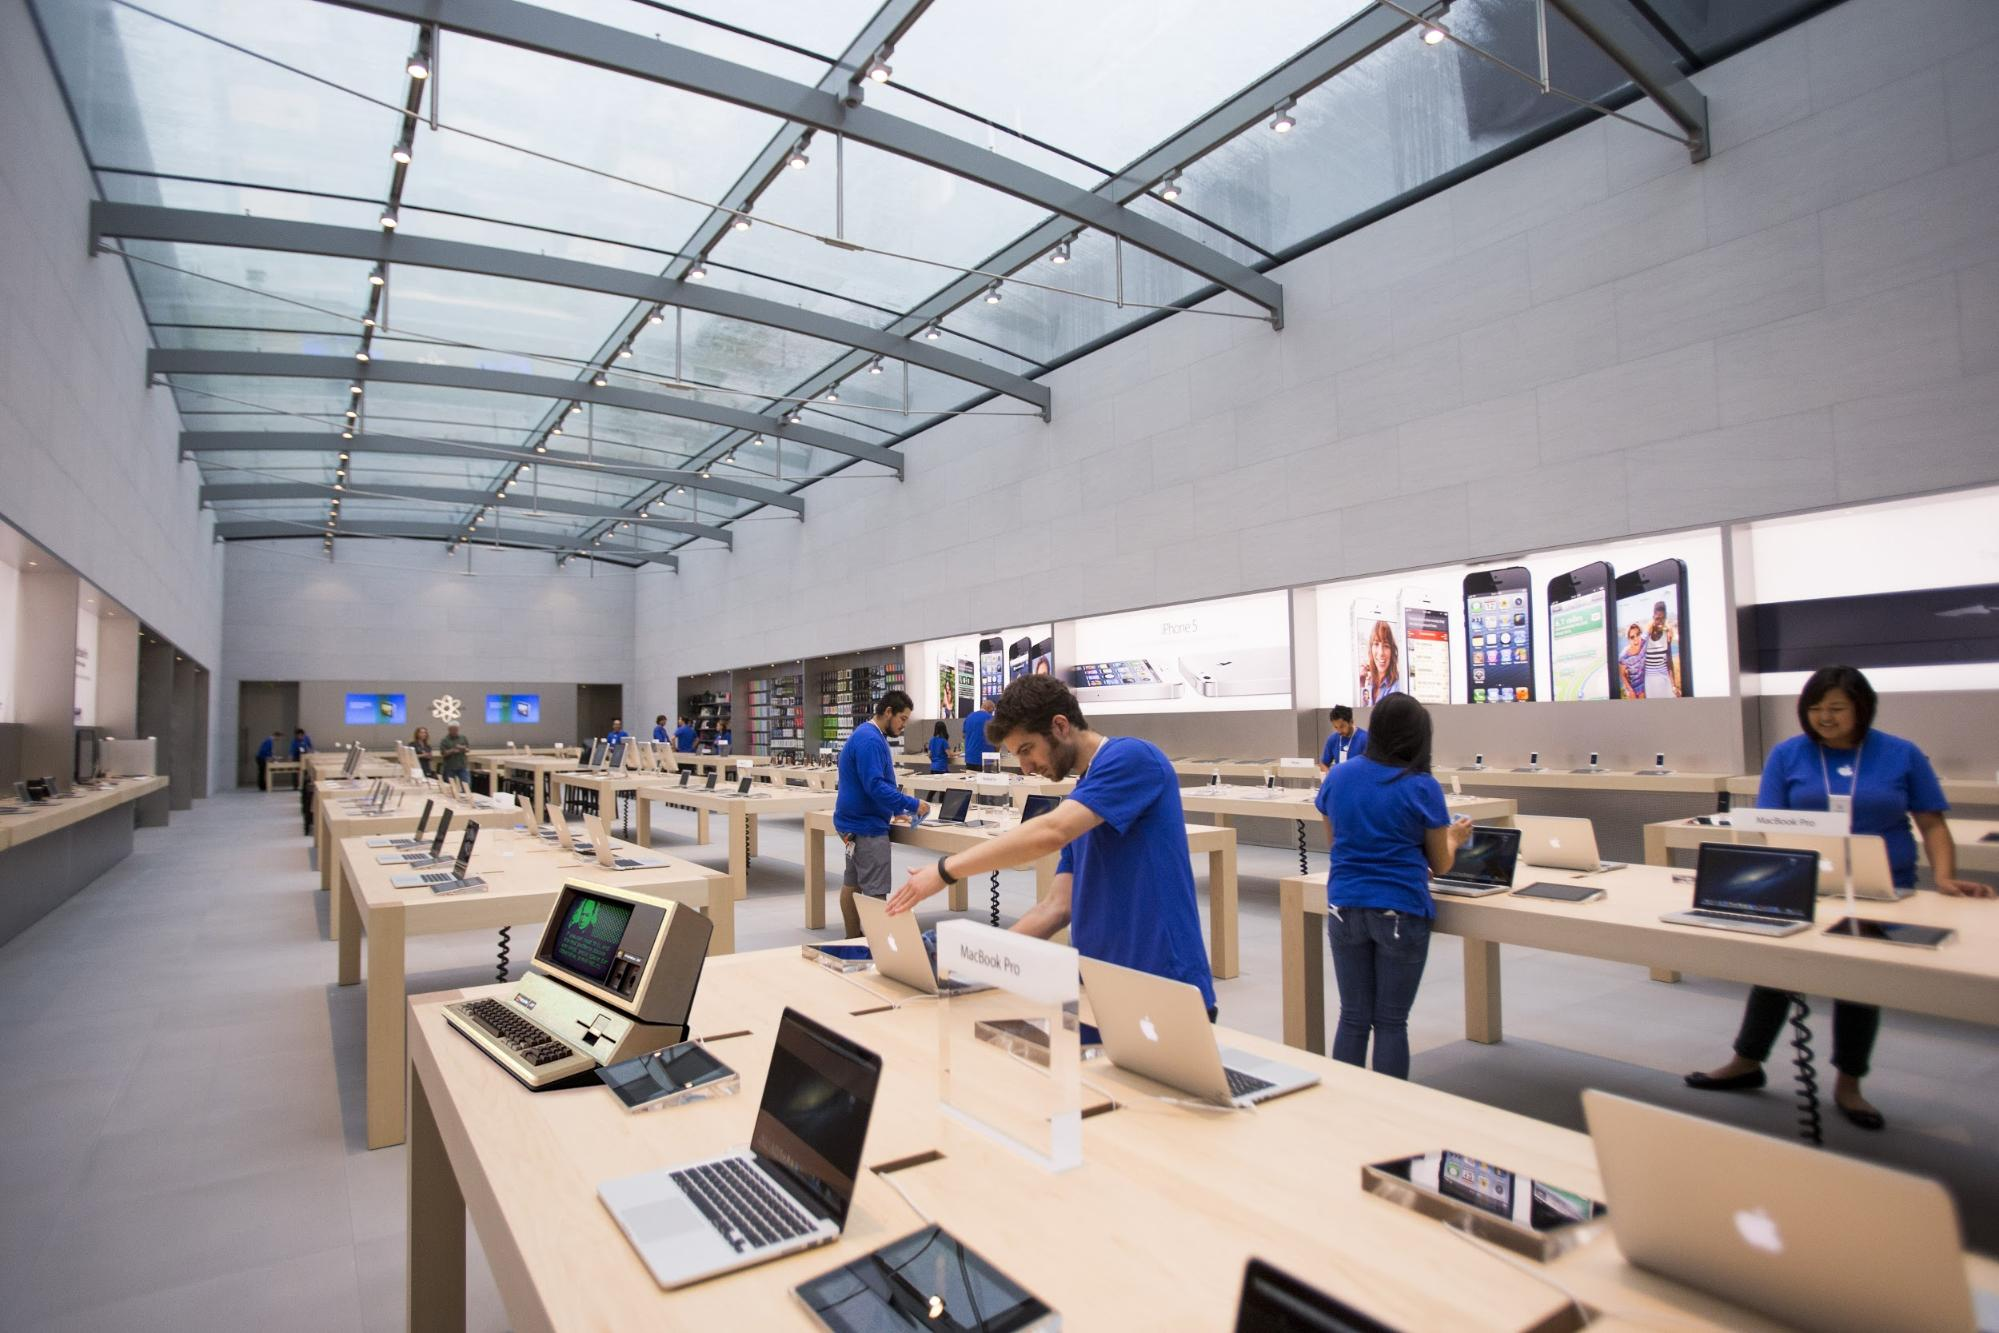

In [24]:
image_file = os.path.join(IMAGES_DIR, "store.jpg")

Image(image_file, width=860)

In [25]:
description = describe_image_with_gpt4o(image_file, "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features")

print(description)

The image depicts the interior of a modern retail store, likely an Apple Store, characterized by its clean, minimalist design and open layout. The key elements in the image are:

1. **Main Objects**:
   - **Tables**: Light-colored wooden tables are arranged in neat rows across the store. They are rectangular and uniformly spaced, creating a sense of order.
   - **Laptops**: Multiple MacBook laptops are displayed on the tables, open and powered on. They are various Apple models, showing screens with different interfaces or applications.
   - **Tablets and Devices**: Some tables also display tablets and other smaller devices, such as iPads or iPhones, secured to the tables with coiled cables.
   - **Signage**: Small white display signs with text like “MacBook Pro” are placed near the devices for informational purposes.

2. **People**:
   - Several individuals wearing blue shirts, presumably staff members, are positioned around the store. They are engaged in various tasks, such as setting

In [26]:
sora_prompt = f"Based on the following descriptions of an image:\n {description} \nPlease create a coherent generative AI prompt that can be used to generate a video."

In [27]:
generated_video_file = sora(sora_prompt, width=1280, height=720, n_seconds=7)

02-Jun-2025 11:49:53 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwr7m282emf8sy5q41v69pdz', 'status': 'queued', 'created_at': 1748864993, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': 'Based on the following descriptions of an image:\n The image depicts the interior of a modern retail store, likely an Apple Store, characterized by its clean, minimalist design and open layout. The key elements in the image are:\n\n1. **Main Objects**:\n   - **Tables**: Light-colored wooden tables are arranged in neat rows across the store. They are rectangular and uniformly spaced, creating a sense of order.\n   - **Laptops**: Multiple MacBook laptops are displayed on the tables, open and powered on. They are various Apple models, showing screens with different interfaces or applications.\n   - **Tablets and Devices**: Some tables also display tablets and other smaller devices, such as iPads or iPhones, secured to the tables with coiled cables.\n   - **Si

In [28]:
Video(generated_video_file, width=1024)

In [29]:
video_link = FileLink(path=generated_video_file)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/image_to_video_sora_02Jun2025_114953_store.mp4

In [30]:
# Mixing the initial image on the left and the SORA video on the right
output_path = os.path.join(OUTPUT_DIR, "image_sora_store.mp4")

left_image = cv2.imread(image_file)
video = cv2.VideoCapture(generated_video_file)

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
left_image_resized = cv2.resize(
    left_image,
    (int(height * left_image.shape[1] / left_image.shape[0]), height))
combined_width = left_image_resized.shape[1] + width
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, height))

while True:
    ret, frame = video.read()
    if not ret:
        break
    combined_frame = np.hstack((left_image_resized, frame))
    out.write(combined_frame)

video.release()
out.release()

video_link = FileLink(path=output_path)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/image_sora_store.mp4

## Generated videos

In [31]:
!ls videos/image_sora*.mp4 -lh

-rwxrwxrwx 1 root root  13M Jun  2 11:48 videos/image_sora_car.mp4
-rwxrwxrwx 1 root root 4.7M Jun  2 11:49 videos/image_sora_food.mp4
-rwxrwxrwx 1 root root 8.7M Jun  2 11:50 videos/image_sora_store.mp4
